In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
data_postulantes = pd.read_csv('data-tp/postulantes_genero_edad_limpio.csv')
data_vistas = pd.read_csv('data-tp/vistas_limpio.csv')
data_detalles = pd.read_csv('data-tp/avisos_detalles.csv')


In [3]:
postulantes_vistas = pd.merge(data_postulantes, data_vistas, on='idpostulante', how= 'inner')

In [4]:
postulantes_vistas['fecha_nacimiento_dt'] = pd.to_datetime(postulantes_vistas['fechanacimiento'], errors= 'coerce')
postulantes_vistas['age'] = postulantes_vistas['fecha_nacimiento_dt'].apply(lambda x: 2018 - x.year)


In [5]:
#vistas_counts = postulantes_vistas['idpostulante'].value_counts().to_frame()
#postulantes_vistas_sd = postulantes_vistas.drop_duplicates('idpostulante')
postulantes_vistas_count = postulantes_vistas.groupby(['idpostulante', 'age']).count().reset_index()

In [6]:
postulantes_vistas_count = postulantes_vistas_count[['idpostulante','age','fechanacimiento']]
postulantes_vistas_count.columns = ['id_postulante','age','avisos_vistos']

In [7]:
postulantes_avisos_mean = postulantes_vistas_count.groupby('age').mean().reset_index()
postulantes_avisos_mean.columns = ['age','avisos_vistos_mean']

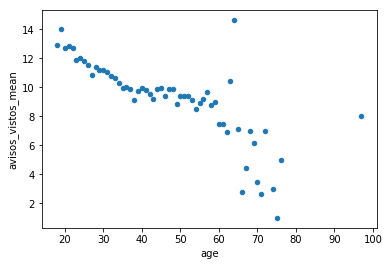

In [8]:
%matplotlib inline
postulantes_avisos_mean.plot.scatter('age','avisos_vistos_mean')


## Grafico la cantidad de avisos promedio de la gente menor a 40 años, discriminado por sexo.

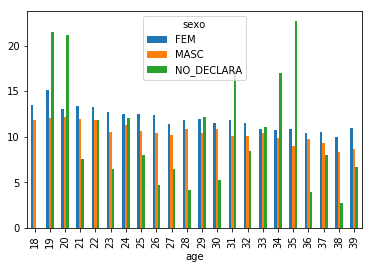

In [9]:
postulantes_sexo_edad = postulantes_vistas.groupby(['idpostulante', 'sexo','age']).count().reset_index()[['sexo','idAviso','age']]
postulantes_sexo_edad_men_30 = postulantes_sexo_edad[postulantes_sexo_edad['age'] < 40]
postulantes_sexo_edad_men_30 = postulantes_sexo_edad_men_30.groupby(['sexo','age']).mean().reset_index()
postulantes_sexo_edad_men_30.columns = ['sexo','age','mean']
postulantes_sexo_edad_men_30.pivot(index = 'age', columns = 'sexo', values = 'mean').plot(kind='bar')

# El plot quedo gigante, quizas se puede particionar mas todavia.

## idem arriba, para la gente entre 40-70 años.

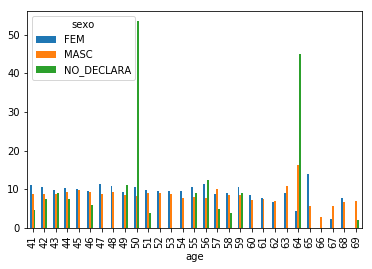

In [10]:
postulantes_sexo_edad_men_70 = postulantes_sexo_edad[(postulantes_sexo_edad['age'] > 40) & (postulantes_sexo_edad['age']<70)]
postulantes_sexo_edad_men_70 = postulantes_sexo_edad_men_70.groupby(['sexo','age']).mean().reset_index()
postulantes_sexo_edad_men_70.columns = ['sexo','age','mean']
postulantes_sexo_edad_men_70.pivot(index = 'age', columns = 'sexo', values = 'mean').plot(kind='bar')

In [11]:
data_carreras = pd.read_csv('data/fiuba_1_postulantes_educacion.csv',error_bad_lines=False)


## Obtengo el titulo mas "alto" de cada id.

In [12]:
carrers_by_priority = ['Secundario','Terciario/Técnico','Otro','Universitario','Posgrado','Master','Doctorado']
def get_higher_carrer(serie):
    high = 0
    for index in range(len(carrers_by_priority)):
        for carrer in serie['nombre']:
            if(carrers_by_priority[index] == carrer):
                high = index if index > high else high
    return carrers_by_priority[high]

data_carreras_fil = data_carreras.groupby('idpostulante').agg(get_higher_carrer).reset_index()[['idpostulante','nombre']]

In [13]:
data_carreras_fil = data_carreras.merge(data_carreras_fil, how = 'left', on=['idpostulante','nombre'])

In [14]:
data_carreras_univ = data_carreras_fil[data_carreras_fil['nombre'] == 'Universitario']


## ¿Buscan más trabajo las personas que están estudiando una carrera o los que se graduaron?

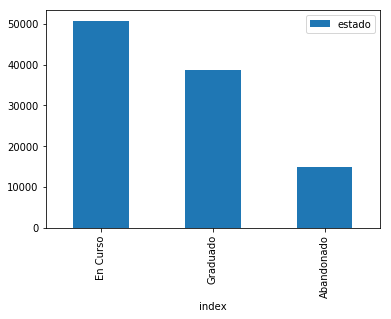

In [15]:
data_carreras_univ['estado'].value_counts().to_frame().reset_index().plot.bar(x='index',y='estado')

## Busco cuales son las empresas con mas avisos vistos

In [16]:
postulantes_vistas_detalles = postulantes_vistas.merge(data_detalles, on = 'idAviso', how ='inner')

In [17]:
empresas_por_avisos = postulantes_vistas_detalles.groupby('denominacion_empresa').count().reset_index()[['denominacion_empresa','idpostulante']]

In [18]:
empresas_por_avisos.columns = ['denominacion_empresa','cantidad_avisos']
top_ten_avisos_empresas = empresas_por_avisos.sort_values(by='cantidad_avisos', ascending = False)[:10]['denominacion_empresa']

In [19]:
postulantes_sexo_area = postulantes_vistas_detalles[(postulantes_vistas_detalles['denominacion_empresa'].isin(top_ten_avisos_empresas))]
postulantes_sexo_area = postulantes_sexo_area.groupby(['denominacion_empresa','sexo']).count().reset_index()[['denominacion_empresa','sexo','idpostulante']]

In [20]:
postulantes_sexo_area.columns = ['denominacion_empresa','sexo','cantidad_postulantes']

## La distribucion de genero entre las 10 empresas con mas avisos es bastante igualitaria. (Recordar, son los avisos vistos por las personas, no el resultado final de contratacion)

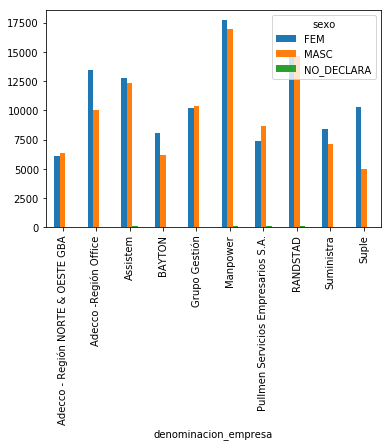

In [21]:
postulantes_sexo_area.pivot(index = 'denominacion_empresa', columns= 'sexo', values='cantidad_postulantes').plot(kind='bar')

### Esto me da la sugerencia de que las empresas "mas grandes" son las mas igualitaria. Vamos a evaluar usando un scatter plot la relacion y si es cierto

In [22]:
postulantes_sexo_area = postulantes_vistas_detalles.groupby(['denominacion_empresa','sexo']).count().reset_index()[['denominacion_empresa','sexo','idpostulante']]

In [23]:
postulantes_sexo_area = postulantes_sexo_area.pivot_table(index='denominacion_empresa', columns='sexo',values='idpostulante')

In [24]:
postulantes_sexo_area['delta_sex'] = (abs(postulantes_sexo_area['FEM'] - postulantes_sexo_area['MASC'])) / (postulantes_sexo_area['FEM'] + postulantes_sexo_area['MASC'])

In [43]:
empresas_vistas_delta_sex = postulantes_sexo_area.merge(empresas_por_avisos, on= 'denominacion_empresa', how = 'inner')

### 

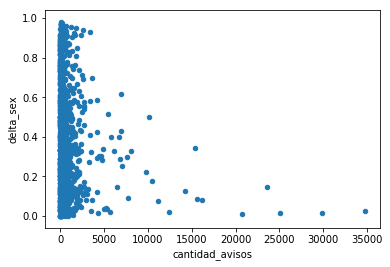

In [46]:
empresas_vistas_delta_sex[empresas_vistas_delta_sex['cantidad_avisos'] > 10]\
                        .plot.scatter(x='cantidad_avisos', y='delta_sex')

### En el siguiente bloxplot. Podemos observar que los datos estan distribuidos de forma simetrica. El 50% de los datos (Por debajo del segundo cuartil) se encuentran entre los valores ~0.35 y ~0.0 . Lo cual nos permite deducir que en el %50 de las empresas, los avisos resultan interesantes para ambos sexos. Sin embargo, entre lo valores ~0.6 y ~1.0 se encuentran el %25 de las empresas. Es decir, en la balanza entre los generos que miran los avisos esta bastante desbalanceada. ¿A qué se debe? ¿Será por el área al cual se enfocan estas empresas?

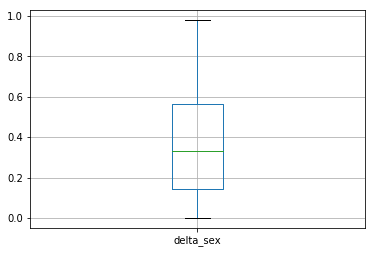

In [25]:
postulantes_sexo_area = postulantes_sexo_area.reset_index()
postulantes_sexo_area['delta_sex'].to_frame().boxplot('delta_sex')

### Vamos a analizar cuales son las areas a la que se dedican las empresas que tienen más del 0.5 de delta_sex

In [26]:
vistas_delta_sex_25_percent = postulantes_sexo_area[postulantes_sexo_area['delta_sex'] > 0.5]

In [27]:
empresas_delta_sex_25_percent = vistas_delta_sex_25_percent.merge(data_detalles.drop_duplicates(subset ='denominacion_empresa'), on='denominacion_empresa', how='inner') \
                                [['nombre_area','denominacion_empresa']]

### La mayoria de las empresas que superan el 0.5 en la escala de desigualdad de genero parecen pertenecer al sector de ventas. Averiguemos cual es el genero que mas esta interesado en esta area

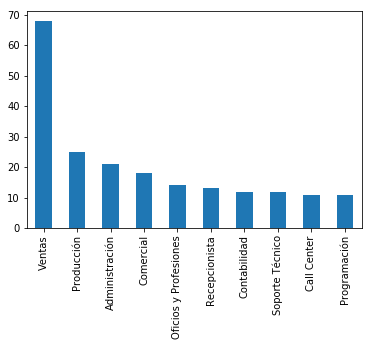

In [28]:
empresas_delta_sex_25_percent['nombre_area'].value_counts().head(10).plot.bar()

In [30]:
postulantes_ventas = postulantes_vistas_detalles[postulantes_vistas_detalles['nombre_area'] == 'Ventas']

### Con el siguiente grafico. Concluimos que el sexo más interesado en el area de ventas, area donde hay mayor desigualdad de genero, es el sexo femenino.

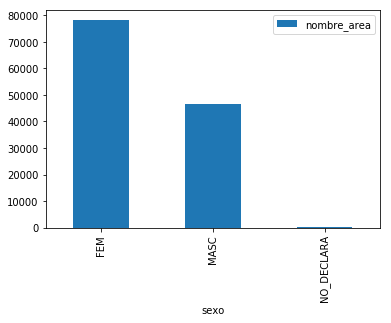

In [41]:
postulantes_ventas[['nombre_area','sexo']].groupby('sexo').count().plot.bar()